In [223]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
import pandas as pd

In [224]:
maxIter = 500            # Maximum iterations to be carried out to get the parameters
C_Lambda = .01           # Regularization relevance constant
TrainingPercent = 80     # Training set
ValidationPercent = 10   # Validation set
TestPercent = 10         # Test Set
M = 100                  # Number of Basis Functions
PHI = []                 # Design matrix

## Cleaning and Merging Datasets 

In [231]:
# filePath is the Dataset to be processed
# same_pairs and diffn_pairs are the target values
# dataType = 0 or 1 => GSC or Human Observed Dataset
# featureProcess = 0 or 1 => Concatenate or Subtract image features
# WORK IT FOR HUMAN OBSERVED !!

def GenerateRawData(filePath, same_pairs, diffn_pairs, datasetType, featureProcess):    
    file_matrix = []
    sp_matrix = []
    dp_matrix = []

# Creating the Dataset Matrix 

    with open(filePath, 'rU') as fi:
        with open(same_pairs, 'rU') as sp:
            with open(diffn_pairs, 'rU') as dp: 
                    
                reader_fi = csv.reader(fi)
                for row in reader_fi:
                    file_matrix.append(row)
                file_matrix = np.delete(file_matrix, 0, axis=0)            # Deleting img_id and column labels
                
                if (datasetType == 1):
                    file_matrix = np.delete(file_matrix, 0, axis=1)        # Deleting sr_no from Human Observed Data 
                
# Code for cleaning data (deleting null features) for GSC
# Because their values are 0 for all instances. Before transpose, features are columns. Hence, axis = 1 
                if (datasetType == 0):
                    file_matrix = np.delete(file_matrix, [452, 454, 458], axis=1)  
                
# Creating same_pair writers matrix
                reader_sp = csv.reader(sp)
                for row in reader_sp:
                    sp_matrix.append(row)
                sp_matrix = np.delete(sp_matrix, 0, axis=0)

# Creating diffn_pair writers matrix with same number of items as same_pair writers matrix
# for fair training by linear regression algorithm i.e. avoid skew

                reader_dp = csv.reader(dp)
                for row in reader_dp:
                    dp_matrix.append(row)
                dp_matrix = np.delete(dp_matrix, 0, axis=0)
                dp_matrix = dp_matrix[:len(sp_matrix)]

# Creating a dictionary, where key is the image name and values are the feature value               
                
                x = np.array(file_matrix)
    
    # dict_data = {'img_id' : [features]}
    dict_data = {}            
    for row in range(x.shape[0]): 
        dict_data[x[row, 0]] = x[row, 1:]

# Creating a combined dataset based on same and different pair of writer combinations

    if (featureProcess == 0):
        rows = 2 * sp_matrix.shape[0]
        columns = 2 * x.shape[1] - 1

        dataMatrix = np.zeros((rows, columns))

        for row in range(sp_matrix.shape[0]):    
            dataMatrix[row] = np.concatenate((np.asarray(dict_data[sp_matrix[row, 0]], dtype=float), np.asarray(dict_data[sp_matrix[row, 1]], dtype=float), np.asarray(dp_matrix[row, 2], dtype=float)), axis = None)

        for row in range(dp_matrix.shape[0]):    
            dataMatrix[row + sp_matrix.shape[0]] = np.concatenate((np.asarray(dict_data[dp_matrix[row, 0]], dtype=float), np.asarray(dict_data[dp_matrix[row, 1]], dtype=float), np.asarray(dp_matrix[row, 2], dtype=float)), axis = None)

            
    if (featureProcess == 1):
        rows = 2 * sp_matrix.shape[0]
        columns = x.shape[1]
        
        dataMatrix = np.zeros((rows, columns))      
        for row in range(len(sp_matrix)):    
            data_row = np.subtract(np.asarray(dict_data[sp_matrix[row, 0]], dtype=float), np.asarray(dict_data[sp_matrix[row, 1]], dtype=float))
            
            data_row = np.append(data_row, np.asarray(sp_matrix[row, 2], dtype=float))
            
            dataMatrix[row] = data_row
        
        for row in range(dp_matrix.shape[0]):  
            data_row = np.subtract(np.asarray(dict_data[dp_matrix[row, 0]], dtype=float), np.asarray(dict_data[dp_matrix[row, 1]], dtype=float))
            data_row = np.append(data_row, np.asarray(dp_matrix[row, 2], dtype=float))
            
            dataMatrix[row + len(sp_matrix) - 1] = data_row        

# Shuffle Data for randomizations, then seperate input and target

    np.random.shuffle(dataMatrix)
    dataMatrix = np.transpose(dataMatrix)

    return dataMatrix

## Preparing the Four Datasets

In [232]:
# Human Observed Dataset with feature concatenation
mix_data = GenerateRawData('HumanObserved-Features-Data.csv', 'same_pairs_obs.csv', 'diffn_pairs_obs.csv', 1, 0)
RawTrainingDataObs_concat = np.delete(mix_data, len(mix_data)-1, 0)
TargetVectorObs_concat = mix_data[len(mix_data)-1]

# Human Observed Dataset with feature subtraction
mix_data = GenerateRawData('HumanObserved-Features-Data.csv', 'same_pairs_obs.csv', 'diffn_pairs_obs.csv', 1, 1)
RawTrainingDataObs_sub = np.delete(mix_data, len(mix_data)-1, 0)
TargetVectorObs_sub = mix_data[len(mix_data)-1]

# GSC Dataset with feature concatenation
mix_data = GenerateRawData('GSC-Features.csv', 'same_pairs_gsc.csv', 'diffn_pairs_gsc.csv', 0, 0)
RawTrainingDataGSC_concat = np.delete(mix_data, len(mix_data)-1, 0)
TargetVectorGSC_concat = mix_data[len(mix_data)-1]

# GSC Dataset with feature subtraction
mix_data = GenerateRawData('GSC-Features.csv', 'same_pairs_gsc.csv', 'diffn_pairs_gsc.csv', 0, 1)
RawTrainingDataGSC_sub = np.delete(mix_data, len(mix_data)-1, 0)
TargetVectorGSC_sub = mix_data[len(mix_data)-1]

E:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: DeprecationWarning: 'U' mode is deprecated
E:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: 'U' mode is deprecated
E:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: 'U' mode is deprecated


MemoryError: 

# <font color=orange> Linear Regression </font>

### Functions used

In [233]:
def GenerateTrainingTarget(rawTraining,TrainingPercent):

# This function selects the number of columns (target values) from targetMatrix as per percent of dataset used for training

    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    print(".." + str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent):
    
# This function selects the number of columns (instances) from dataMatrix as per the percent of dataset used for training
    
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent)) 

# We now select all features and the number of instances selected above    
    
    d2 = rawData[:,0:T_len]
    print(".." + str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    
# This function selects the number of columns from dataMatrix as per the percent of dataset used for validation

    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))

# The percent of input dataset, after training set is used for validation. Here, we set the limit for validation set.
    
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    print (".." + str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawTarget, ValPercent, TrainingCount):    # changed rawData --> rawTarget for easy readability  
    
# This function selects the number of columns (target values) from targetMatrix as per percent of dataset used for 
# validation.
    
    valSize = int(math.ceil(len(rawTarget)*ValPercent*0.01))
    
# The percent of target dataset, after training-target set is used for validation. We set the limit for validation set.
    
    V_End = TrainingCount + valSize
    t =rawTarget[TrainingCount+1:V_End]
    print (".." + str(ValPercent) + "% Val Target Data Generated..")
    return t

def GenerateBigSigma(Data, MuMatrix,TrainingPercent):
    BigSigma    = np.zeros((len(Data),len(Data)))                   # BigSigma - diagonal matrix of variances for features

# converting Data to conventional stats form, rows: observations, columns: features

    DataT       = np.transpose(Data)                               
    
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):

# For each feature at column 'i', we seperate feature data into a vector, and calculate its variance

            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
# Now we enter variance of each features into the diagonal of BigSigma Matrix

    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
        
    
# We scale the BigSigma values i.e. variance of every feature by a scalar.
# We do this to increase the spread of the data, to accurately calculate ERMS and avoid overlap.
        
    BigSigma = np.dot(200,BigSigma)
    print ("..BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):

# for 'M' radial basis functions, we calculate its exponents 
    
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    
#  Generating design matrix by calling GetRadialBasisOut for each x and \mu
    
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    print ("..PHI Generated..")
    return PHI

def GetWeightsClosedForm(PHI, T, Lambda):

# As per the formula of the closed form solution with least squared regularization, we calculate weights
# The equation is similar to Moore-Penrose Pseudo Inverse Matrix of \phi with an added regularization term

    Lambda_I = np.identity(len(PHI[0]))                            # Coefficient of Regularization Term * Identity Matrix
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda                                 
    PHI_T       = np.transpose(PHI)                                
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)                         
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    print ("..Training Weights Generated..")
    return W

def GetValTest(VAL_PHI,W):                                         # We apply linear regression to validation set
    Y = np.dot(W,np.transpose(VAL_PHI))
    print ("..Test Out Generated..")
    return Y

def GetErms(VAL_TEST_OUT,ValDataAct):                               
    
# calculate root mean squared error between target validation set and predicted validation set outputs
# E_rms = \sqrt{ \sigma{(actual value - predicted value)^2}}
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range(len(VAL_TEST_OUT) - 1):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)           
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))              # accuracy = correct_predictions / total 
    print ("..Accuracy Generated..")
    print ("..Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Prepare Training Data

In [234]:
# Human Observed Dataset with feature concatenation
TrainingTargetObs_concat = np.array(GenerateTrainingTarget(TargetVectorObs_concat,TrainingPercent))
TrainingDataObs_concat   = GenerateTrainingDataMatrix(RawTrainingDataObs_concat,TrainingPercent)
print(TrainingTargetObs_concat.shape)
print(TrainingDataObs_concat.shape)

# Human Observed Dataset with feature subtraction
TrainingTargetObs_sub = np.array(GenerateTrainingTarget(TargetVectorObs_sub,TrainingPercent))
TrainingDataObs_sub   = GenerateTrainingDataMatrix(RawTrainingDataObs_sub,TrainingPercent)
print(TrainingTargetObs_sub.shape)
print(TrainingDataObs_sub.shape)

# GSC Dataset with feature concatenation
TrainingTargetGSC_concat = np.array(GenerateTrainingTarget(TargetVectorGSC_concat,TrainingPercent))
TrainingDataGSC_concat   = GenerateTrainingDataMatrix(RawTrainingDataGSC_concat,TrainingPercent)
print(TrainingTargetGSC_concat.shape)
print(TrainingDataGSC_concat.shape)

# GSC Dataset with feature subtraction
TrainingTargetGSC_sub = np.array(GenerateTrainingTarget(TargetVectorGSC_sub,TrainingPercent))
TrainingDataGSC_sub   = GenerateTrainingDataMatrix(RawTrainingDataGSC_sub,TrainingPercent)
print(TrainingTargetGSC_sub.shape)
print(TrainingDataGSC_sub.shape)

..80% Training Target Generated..
..80% Training Data Generated..
(1266,)
(18, 1266)
..80% Training Target Generated..
..80% Training Data Generated..
(1266,)
(9, 1266)
..80% Training Target Generated..
..80% Training Data Generated..
(114450,)
(1018, 114450)
..80% Training Target Generated..
..80% Training Data Generated..
(114450,)
(509, 114450)


## Prepare Validation Data

In [235]:
# Human Observed Dataset with feature concatenation
ValDataActObs_concat = np.array(GenerateValTargetVector(TargetVectorObs_concat,ValidationPercent, (len(TrainingTargetObs_concat))))
ValDataObs_concat = GenerateValData(RawTrainingDataObs_concat,ValidationPercent, (len(TrainingDataObs_concat)))
print(ValDataActObs_concat.shape)
print(ValDataObs_concat.shape)

# Human Observed Dataset with feature subtraction
ValDataActObs_sub = np.array(GenerateValTargetVector(TargetVectorObs_sub,ValidationPercent, (len(TrainingTargetObs_sub))))
ValDataObs_sub    = GenerateValData(RawTrainingDataObs_sub,ValidationPercent, (len(TrainingDataObs_sub)))
print(ValDataActObs_sub.shape)
print(ValDataObs_sub.shape)

# GSC Dataset with feature concatenation
ValDataActGSC_concat = np.array(GenerateValTargetVector(TargetVectorGSC_concat,ValidationPercent, (len(TrainingTargetGSC_concat))))
ValDataGSC_concat = GenerateValData(RawTrainingDataGSC_concat,ValidationPercent, (len(TrainingDataGSC_concat)))
print(ValDataActGSC_concat.shape)
print(ValDataGSC_concat.shape)

# GSC Dataset with feature subtraction
ValDataActGSC_sub = np.array(GenerateValTargetVector(TargetVectorGSC_sub,ValidationPercent, (len(TrainingTargetGSC_sub))))
ValDataGSC_sub = GenerateValData(RawTrainingDataGSC_sub,ValidationPercent, (len(TrainingDataGSC_sub)))
print(ValDataActGSC_sub.shape)
print(ValDataGSC_sub.shape)

..10% Val Target Data Generated..
..10% Val Data Generated..
(158,)
(18, 158)
..10% Val Target Data Generated..
..10% Val Data Generated..
(158,)
(9, 158)
..10% Val Target Data Generated..
..10% Val Data Generated..
(14306,)
(1018, 14306)
..10% Val Target Data Generated..
..10% Val Data Generated..
(14306,)
(509, 14306)


## Prepare Test Data

In [236]:
# we reuse GenerateValTargetVector and GenerateValData, but pass section of the dataset after the validation set
# i.e. the remaining dataset

# Human Observed Dataset with feature concatenation
TestDataActObs_concat = np.array(GenerateValTargetVector(TargetVectorObs_concat,TestPercent, len(TrainingTargetObs_concat)+len(ValDataActObs_concat)))
TestDataObs_concat = GenerateValData(RawTrainingDataObs_concat,TestPercent, len(TrainingDataObs_concat)+len(ValDataObs_concat))   
print(TestDataActObs_concat.shape)
print(TestDataObs_concat.shape)

# Human Observed Dataset with feature subtraction
TestDataActObs_sub = np.array(GenerateValTargetVector(TargetVectorObs_sub, TestPercent, len(TrainingTargetObs_sub)+len(ValDataActObs_sub)))
TestDataObs_sub = GenerateValData(RawTrainingDataObs_sub,TestPercent, len(TrainingDataObs_sub)+len(ValDataObs_sub))   
print(TestDataActObs_sub.shape)
print(TestDataObs_sub.shape)

# GSC Dataset with feature concatenation
TestDataActGSC_concat = np.array(GenerateValTargetVector(TargetVectorGSC_concat,TestPercent, len(TrainingTargetGSC_concat)+len(ValDataGSC_concat)))
TestDataGSC_concat = GenerateValData(RawTrainingDataGSC_concat,TestPercent, len(TrainingDataGSC_concat)+len(ValDataGSC_concat))   
print(TestDataActGSC_concat.shape)
print(TestDataGSC_concat.shape)

# GSC Dataset with feature subtraction
TestDataActGSC_sub = np.array(GenerateValTargetVector(TargetVectorGSC_sub, TestPercent, len(TrainingTargetGSC_sub)+len(ValDataGSC_sub)))
TestDataGSC_sub = GenerateValData(RawTrainingDataGSC_sub,TestPercent, len(TrainingDataGSC_sub)+len(ValDataGSC_sub))   
print(TestDataActGSC_sub.shape)
print(TestDataGSC_sub.shape)

..10% Val Target Data Generated..
..10% Val Data Generated..
(157,)
(18, 158)
..10% Val Target Data Generated..
..10% Val Data Generated..
(157,)
(9, 158)
..10% Val Target Data Generated..
..10% Val Data Generated..
(14306,)
(1018, 14306)
..10% Val Target Data Generated..
..10% Val Data Generated..
(14306,)
(509, 14306)


## Select input dataset

In [237]:
# Meta list of Comprehensive Datasets
DataList = [RawTrainingDataObs_concat, RawTrainingDataObs_sub, RawTrainingDataGSC_concat, RawTrainingDataGSC_sub]
TargetList = [TargetVectorObs_concat, TargetVectorObs_sub, TargetVectorGSC_concat, TargetVectorGSC_sub]

# Meta list of Training Datasets
TrainingList = [TrainingDataObs_concat, TrainingDataObs_sub, TrainingDataGSC_concat, TrainingDataGSC_sub]
TrainingTargetList = [TrainingTargetObs_concat, TrainingTargetObs_sub, TrainingTargetGSC_concat, TrainingTargetGSC_sub]

# Meta list of Validation Datasets
ValList = [ValDataObs_concat, ValDataObs_sub, ValDataGSC_concat, ValDataGSC_sub]
ValActList = [ValDataActObs_concat, ValDataActObs_sub, ValDataActGSC_concat, ValDataActGSC_sub]

# Meta list of Testing Datasets
TestList = [TestDataObs_concat, TestDataObs_sub,TestDataGSC_concat, TestDataGSC_sub]
TestActList = [TestDataActObs_concat, TestDataActObs_sub, TestDataActGSC_concat, TestDataActGSC_sub]

x = 0

RawData = DataList[x]                          # Comprehensive Dataset
TargetData = TargetList[x]                     # Target Vector of the selected Dataset

TrainingTarget = TrainingTargetList[x]         # Target Vector for Training dataset
TrainingData = TrainingList[x]                 # Training Dataset

ValData = ValList[x]                           # Validation Dataset
ValDataAct = ValActList[x]                     # Target Vector for Validation Dataset

TestData = TestList[x]                         # Testing Dataset
TestDataAct = TestActList[x]                   # Target Vector for Testing Dataset

## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

In [238]:
# \mu i.e the center of the RBFs generated is calculated using kmeans clustering algorithm
# for 'M' no. of basis functions, we need M centers. 
# Results are centroids of the M clusters. A centroid is a data point (imaginary or real) at the center of a cluster.

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

# We pass these generated Mu values into all the other required parameters

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

..BigSigma Generated..
..PHI Generated..
..Training Weights Generated..
..PHI Generated..
..PHI Generated..


In [239]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(100, 18)
(18, 18)
(1266, 100)
(100,)
(158, 100)
(158, 100)


## Finding Erms on training, validation and test set

In [240]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
print("\n..Training Accuracy : " + str(float(TrainingAccuracy.split(',')[0])) + "..\n")

ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
print("\n..Validation Accuracy : " + str(float(ValidationAccuracy.split(',')[0])) + "..\n")

TestAccuracy = str(GetErms(TEST_OUT,TestDataAct))
print("\n..Testing Accuracy : " + str(float(TestAccuracy.split(',')[0])) + "..\n")

..Test Out Generated..
..Test Out Generated..
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0

..Training Accuracy : 99.92101105845181..

..Accuracy Generated..
..Validation E_RMS : 0.0

..Validation Accuracy : 99.36708860759494..

..Accuracy Generated..
..Validation E_RMS : 0.0

..Testing Accuracy : 99.36708860759494..



## Gradient Descent solution for Linear Regression

In [241]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [242]:
W_Now        = np.dot(220, W)        # initialize 'w' vector
La           = .5                    # Regularization relevance constant
learningRate = .05                   # learning rate determines how big each update step is
L_Erms_Val   = []                    # E_rms for validation set
L_Erms_TR    = []                    # E_rms for training set
L_Erms_Test  = []                    # E_rms for testing set
W_Mat        = []                    # weight matrix

for i in range(0,maxIter):
    
    #print ('---------Iteration: ' + str(i) + '--------------')

# We calculate error function at each data point till maxIter, maximum data points used to fit data.

# differentiation of sum of squared errors, to be minimized for maximum likelihood.
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)                                    # 
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test

..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accu

..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test

..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accu

..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Vali

..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test

..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test

..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Vali

..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accu

..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test

..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test Out Generated..
..Accuracy Generated..
..Validation E_RMS : 0.0
..Test

In [243]:
print ('----------Gradient Descent Solution--------------------')
print ("\nLambda  = " + str(La) + " \neta = " + str(learningRate))

# From the maxIter, we compute the rounded minimum E_rms, upto 5 decimals
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print("Training Accuracy: " + str(float(Erms_TR.split(',')[0])))

print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print("Validation Accuracy: " + str(float(Erms_Val.split(',')[0])))

print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
print("Testing Accuracy: " + str(float(Erms_Test.split(',')[0])))

----------Gradient Descent Solution--------------------

Lambda  = 0.5 
eta = 0.05
E_rms Training   = 0.0
Training Accuracy: 99.92101105845181
E_rms Validation = 0.0
Validation Accuracy: 99.36708860759494
E_rms Testing    = 0.0
Testing Accuracy: 99.36708860759494


# <font color=orange>Neural Networks</font>

## Model Definition

In [2]:
import time

start_time = time.clock()

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard

import numpy as np

input_size = RawData.shape[0]
drop_out = 0.2
first_dense_layer_nodes  = 32
second_dense_layer_nodes = 8
output_size = 1

def get_model():
    
    model = Sequential()

# We use the default initializer, init which sets the weight distributed uniformly between 0 and 0.05
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    
# Hidden Layer 1
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('relu'))
    model.add(Dropout(drop_out))
# Output Layer
    model.add(Dense(output_size))
    model.add(Activation('sigmoid'))

    model.summary()

# Compiling the Model as per the given parameters

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

E:\ProgramFiles\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


KeyboardInterrupt: 

## Creating Model

In [245]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 32)                608       
_________________________________________________________________
activation_52 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 8)                 264       
_________________________________________________________________
activation_53 (Activation)   (None, 8)                 0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 9         
_________________________________________________________________
activation_54 (Activation)   (None, 1)                 0         
Total para

## Run Model

In [246]:
validation_data_split = 0.2
num_epochs = 50 
model_batch_size = 128
tb_batch_size = 32
early_patience = 128

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

history = model.fit(RawData.T, TargetData
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )

train_time = time.clock() - start_time

Train on 1265 samples, validate on 317 samples
Epoch 1/50
1265/1265 [==============================] - 1s 796us/step - loss: 1.0899 - acc: 0.2324 - val_loss: 0.7897 - val_acc: 0.3249
Epoch 2/50
1265/1265 [==============================] - 0s 76us/step - loss: 0.6430 - acc: 0.5968 - val_loss: 0.4606 - val_acc: 0.9085
Epoch 3/50
1265/1265 [==============================] - 0s 79us/step - loss: 0.3914 - acc: 0.9146 - val_loss: 0.2809 - val_acc: 1.0000
Epoch 4/50
1265/1265 [==============================] - 0s 78us/step - loss: 0.2790 - acc: 0.9549 - val_loss: 0.1760 - val_acc: 1.0000
Epoch 5/50
1265/1265 [==============================] - 0s 88us/step - loss: 0.1999 - acc: 0.9874 - val_loss: 0.1104 - val_acc: 1.0000
Epoch 6/50
1265/1265 [==============================] - 0s 87us/step - loss: 0.1725 - acc: 0.9810 - val_loss: 0.0693 - val_acc: 1.0000
Epoch 7/50
1265/1265 [==============================] - 0s 109us/step - loss: 0.1558 - acc: 0.9889 - val_loss: 0.0436 - val_acc: 1.0000
Epoch 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000022FCCD9FC50>,
      dtype=object)

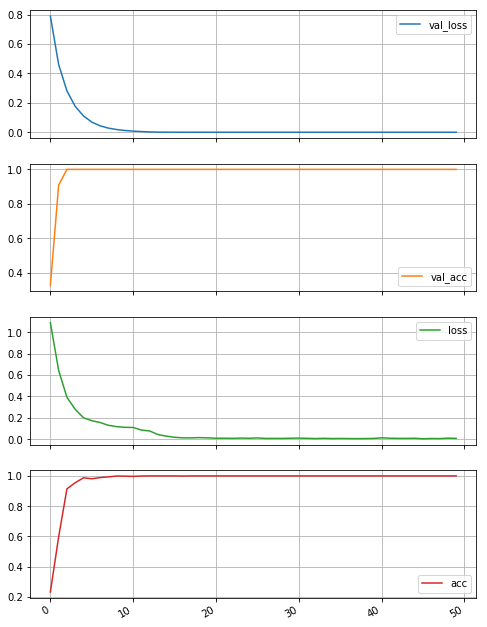

In [247]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(8, 12))

## Testing Accuracy

In [ ]:
test_time = time.clock()

wrong   = 0
right   = 0

for i,j in zip(RawData.T,TargetData):
    y = model.predict(np.array(i).reshape(-1,RawData.shape[0]))
    
    if j.argmax() == y.argmax():
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))

print("Testing Accuracy: " + str(right/(right+wrong)*100))
print("Training Time: %s seconds" % train_time)
print("Testing Time:  %s seconds" % (time.clock() - test_time))

print()
print('Name: Urjit Satish Sardesai')
print('UBIT: urjitsat')


In [249]:
'''
References:
1. NumPy reference : https://docs.scipy.org/doc/numpy/reference/index.html
2. Python reference : https://docs.python.org/3.5/reference/index.html
3. What is the intuitive meaning of a covariance matrix? : https://www.quora.com/What-is-the-intuitive-meaning-of-a-covariance-matrix
4. Moore-Penrose Inverse Matrix : https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse
5. Root mean squared error : https://www.statisticshowto.datasciencecentral.com/rmse/
6. Gradient Descent: https://en.wikipedia.org/wiki/Gradient_descent
7. Hyperparameter Optimization : https://en.wikipedia.org/wiki/Hyperparameter_optimization
'''

'\nReferences:\n1. NumPy reference : https://docs.scipy.org/doc/numpy/reference/index.html\n2. Python reference : https://docs.python.org/3.5/reference/index.html\n3. What is the intuitive meaning of a covariance matrix? : https://www.quora.com/What-is-the-intuitive-meaning-of-a-covariance-matrix\n4. Moore-Penrose Inverse Matrix : https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse\n5. Root mean squared error : https://www.statisticshowto.datasciencecentral.com/rmse/\n6. Gradient Descent: https://en.wikipedia.org/wiki/Gradient_descent\n7. Hyperparameter Optimization : https://en.wikipedia.org/wiki/Hyperparameter_optimization\n'